In [98]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.16.1


In [99]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

In [100]:
import numpy as np

data = np.load("/kaggle/input/mars-for-students-npz/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

## Data cleaning

In [101]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


Img 0


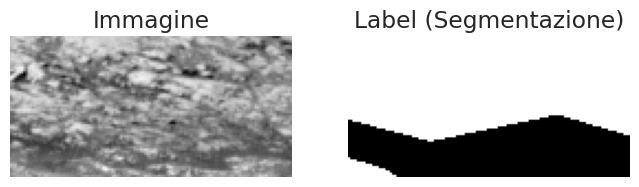

Img 1


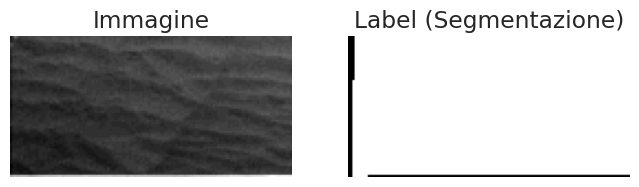

Img 2


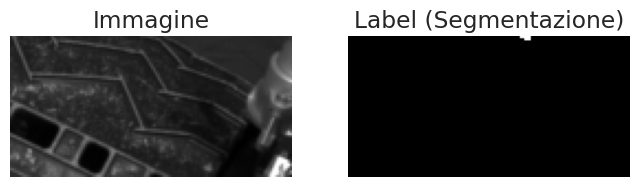

Img 3


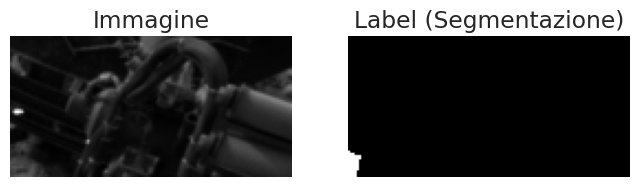

Img 4


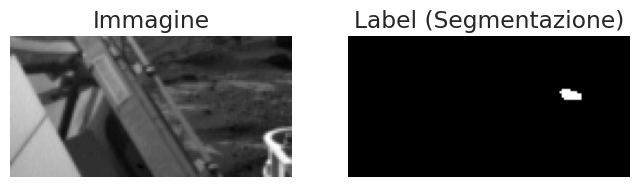

Img 5


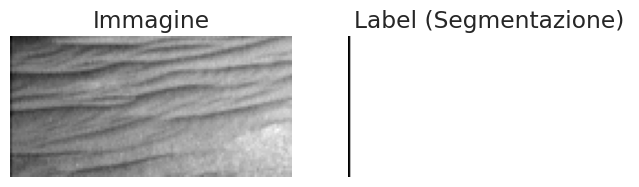

Img 6


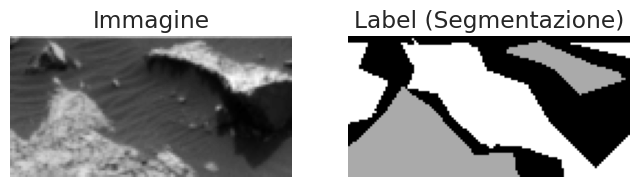

Img 7


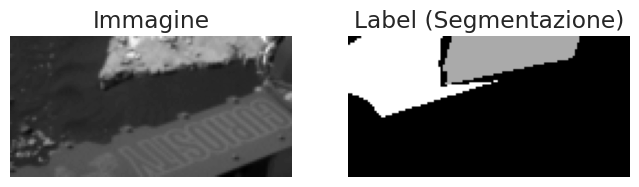

Img 8


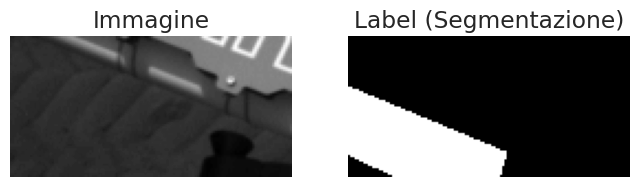

Img 9


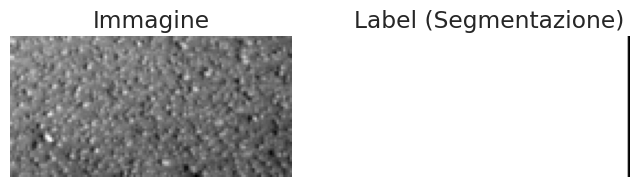

Img 10


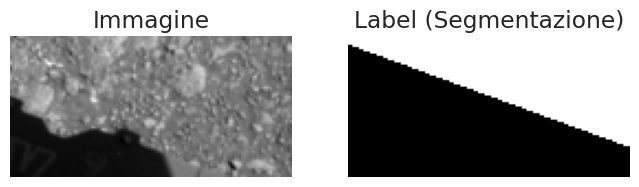

In [102]:
import matplotlib.pyplot as plt

# Supponiamo che X_train contenga le immagini e y_train le etichette di segmentazione
for i, (img, label) in enumerate(zip(X_train, y_train)):
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(i))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Immagine")
    plt.axis('off')
    
    # Label di segmentazione
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray' if len(label.shape) == 2 else None)
    plt.title("Label (Segmentazione)")
    plt.axis('off')
    
    plt.show()

    
    # Limita il numero di immagini mostrate, ad esempio a 10
    if i >= 10:
        break


In [103]:
# Flatten y_train to aggregate pixel counts across all images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [104]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [105]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def attention_gate(skip_connection, gating_signal, inter_channels):
    # Riduzione dimensionale
    theta_x = tfkl.Conv2D(inter_channels, (1, 1), padding="same")(skip_connection)  # Da skip
    phi_g = tfkl.Conv2D(inter_channels, (1, 1), padding="same")(gating_signal)      # Da upsample
    # Somma e attivazione ReLU
    f = tfkl.Activation("relu")(tfkl.Add()([theta_x, phi_g]))
    # Maschera di attenzione
    psi = tfkl.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(f)
    # Applicazione della maschera
    return tfkl.Multiply()([skip_connection, psi])


In [106]:
import keras_cv

def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.1),
        keras_cv.layers.RandomContrast([0, 255], 0.2),
        keras_cv.layers.RandomGaussianBlur(2, 1),
        tf.keras.layers.GaussianNoise(0.05)
    ])
    
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed, name="UNet"):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # Upsampling path
    u4 = tfkl.UpSampling2D()(bottleneck)
    att4 = attention_gate(down_block_4, u4, inter_channels=128)  # Attention gate
    u4 = tfkl.Concatenate()([u4, att4])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    att3 = attention_gate(down_block_3, u3, inter_channels=64)  # Attention gate
    u3 = tfkl.Concatenate()([u3, att3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    att2 = attention_gate(down_block_2, u2, inter_channels=32)
    u2 = tfkl.Concatenate()([u2, att2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    att1 = attention_gate(down_block_1, u1, inter_channels=16)
    u1 = tfkl.Concatenate()([u1, att1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)
    return model

In [107]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}
    
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [108]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""

    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [109]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)
    
    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels
    
    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [110]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=True,
    seed=seed
)

In [111]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)


Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [112]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model()

In [113]:
import random

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)
    
        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
    
        # Apply the colormap
        colored = colormap[label.astype(int)]
    
        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [114]:
import tensorflow.keras.backend as K

total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
    
def compute_distance_map(y_true):
    """
    Approximate the distance map using TensorFlow operations.
    This applies a convolution-based smoothing filter.
    """
    # Ensure y_true is one-hot encoded and float
    y_true = tf.cast(y_true, tf.float32)

    # Define a simple Gaussian kernel for smoothing
    def gaussian_kernel(size: int, sigma: float):
        """
        Create a 2D Gaussian kernel using TensorFlow.
        """
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        y = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x, y = tf.meshgrid(x, y)
        kernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
        kernel = kernel / tf.reduce_sum(kernel)
        return kernel

    kernel_size = 15
    sigma = 5.0
    gaussian = gaussian_kernel(kernel_size, sigma)
    gaussian = gaussian[:, :, tf.newaxis, tf.newaxis]

    distances = []
    for c in range(y_true.shape[-1]):
        class_map = y_true[..., c: c + 1]  # Extract single class channel
        # Apply Gaussian smoothing using 2D convolution
        smoothed = tf.nn.conv2d(
            class_map[tf.newaxis],  # Add batch dimension
            gaussian,
            strides=[1, 1, 1, 1],
            padding="SAME"
        )[0]  # Remove batch dimension
        distances.append(smoothed)

    return tf.stack(distances, axis=-1)

def focal_loss(y_true, y_pred, alpha=0.5, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
    
    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)
    
    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy
    
    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Ensure y_pred is normalized (softmax)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class weights
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    weighted_cross_entropy = weights * cross_entropy
    return tf.reduce_mean(weighted_cross_entropy)
    
def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(dice)



def boundary_loss(y_true, y_pred):
    """
    Boundary Loss: Penalizes differences along the boundary.
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute distance map
    distance_map = compute_distance_map(y_true)
    distance_map = tf.squeeze(distance_map, axis=3)
    
    # Compute boundary loss as the L2 loss between distance map and predicted boundaries
    boundary_diff = distance_map * (y_true - y_pred)
    boundary_loss_value = tf.reduce_mean(tf.square(boundary_diff))
    return boundary_loss_value
    
@tf.function
def combined_loss(y_true, y_pred):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss + Boundary Loss
    """
    loss_ce = weighted_categorical_crossentropy(y_true, y_pred)
    loss_focal = focal_loss(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    loss_boundary = boundary_loss(y_true, y_pred)

    # Aggiungi la stampa dei valori
    #tf.print("CE Loss:", loss_ce * 0.1)
    #tf.print("Focal Loss:", loss_focal)
    #tf.print("Dice Loss:", loss_dice)
    #tf.print("Boundary Loss:", loss_boundary *10)

    # Combine all loss terms with weights
    #return loss_focal + loss_dice + 10 * loss_boundary
    return loss_ce * 0.1 + loss_dice #+ 5 * loss_boundary


# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
        #class_weights=class_weights_tensor
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [115]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',
        mode='max',
        patience=20,
        restore_best_weights=True
    )
    
    viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - loss: 1.7498 - mean_iou: 0.0731

W0000 00:00:1733347880.969430      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

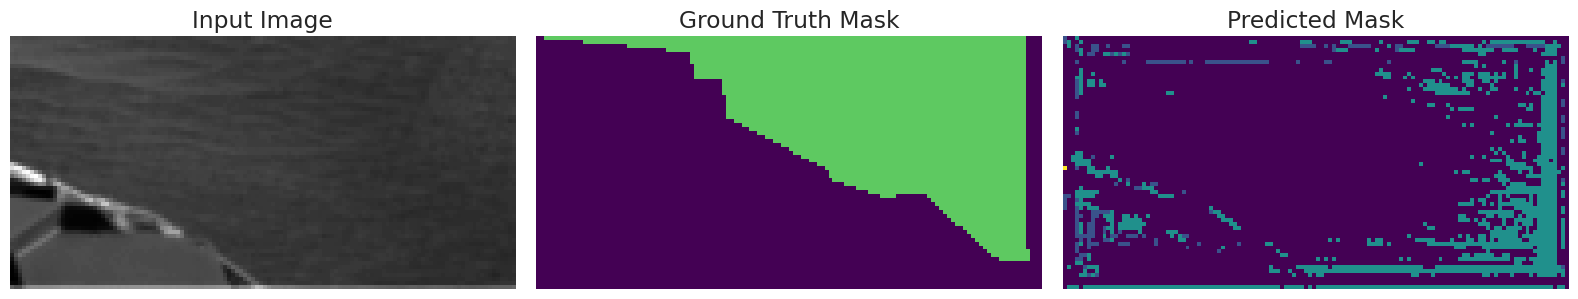

9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 1.7420 - mean_iou: 0.0744 - val_loss: 1.4447 - val_mean_iou: 0.0250
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 784ms/step - loss: 1.5685 - mean_iou: 0.1394 - val_loss: 1.5307 - val_mean_iou: 0.0545
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - loss: 1.4031 - mean_iou: 0.1914 - val_loss: 1.5380 - val_mean_iou: 0.0794
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - loss: 1.3377 - mean_iou: 0.2280 - val_loss: 1.4197 - val_mean_iou: 0.1165
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - loss: 1.2362 - mean_iou: 0.2664 - val_loss: 1.5172 - val_mean_iou: 0.1120
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - loss: 1.1405 - mean_iou: 0.3073

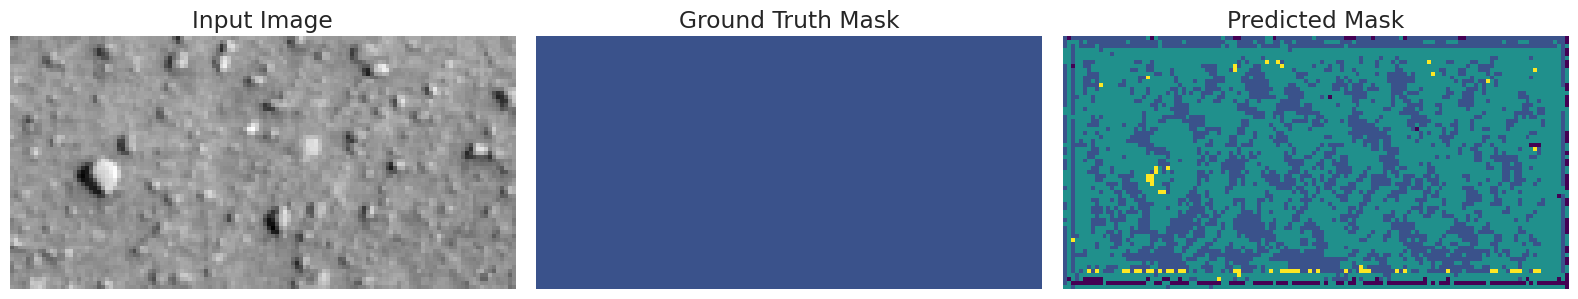

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 798ms/step - loss: 1.1387 - mean_iou: 0.3068 - val_loss: 1.5144 - val_mean_iou: 0.1277
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 705ms/step - loss: 1.1156 - mean_iou: 0.3219 - val_loss: 1.4907 - val_mean_iou: 0.1330
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - loss: 1.0340 - mean_iou: 0.3488 - val_loss: 1.5420 - val_mean_iou: 0.1142
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 700ms/step - loss: 1.0581 - mean_iou: 0.3521 - val_loss: 1.4096 - val_mean_iou: 0.1078
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 696ms/step - loss: 0.9629 - mean_iou: 0.3632 - val_loss: 1.4807 - val_mean_iou: 0.1083
Epoch 11/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - loss: 0.9127 - mean_iou: 0.3927

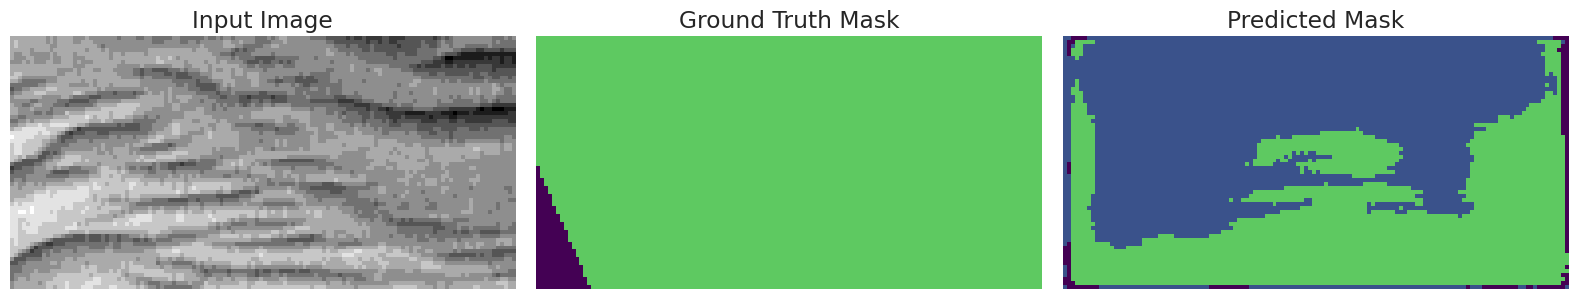

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 801ms/step - loss: 0.9120 - mean_iou: 0.3915 - val_loss: 1.5195 - val_mean_iou: 0.1164
Epoch 12/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - loss: 0.8992 - mean_iou: 0.3995 - val_loss: 1.4959 - val_mean_iou: 0.1109
Epoch 13/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 738ms/step - loss: 0.8814 - mean_iou: 0.4048 - val_loss: 1.3874 - val_mean_iou: 0.1386
Epoch 14/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 726ms/step - loss: 0.8500 - mean_iou: 0.4076 - val_loss: 1.4571 - val_mean_iou: 0.1213
Epoch 15/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 728ms/step - loss: 0.8323 - mean_iou: 0.4210 - val_loss: 1.4575 - val_mean_iou: 0.1360
Epoch 16/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - loss: 0.8307 - mean_iou: 0.4214

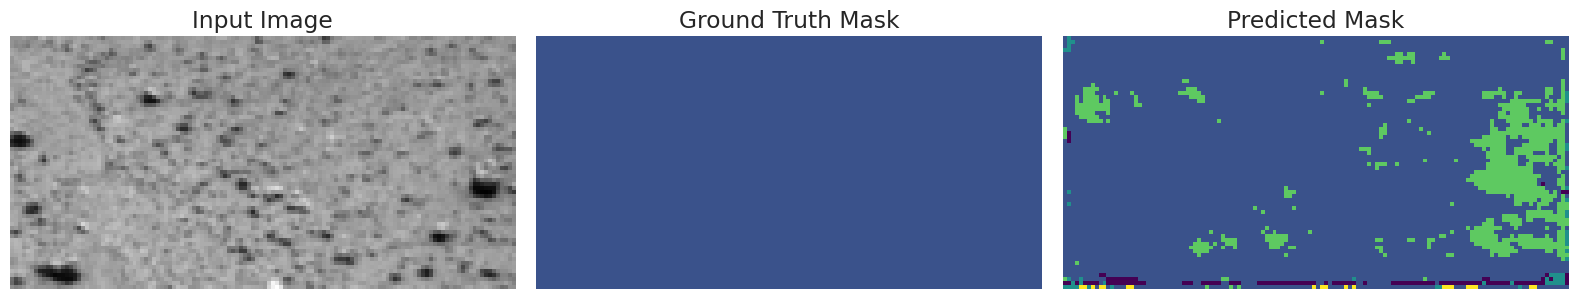

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 797ms/step - loss: 0.8331 - mean_iou: 0.4196 - val_loss: 1.3465 - val_mean_iou: 0.1595
Epoch 17/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - loss: 0.8314 - mean_iou: 0.4201 - val_loss: 1.4303 - val_mean_iou: 0.2066
Epoch 18/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - loss: 0.8010 - mean_iou: 0.4496 - val_loss: 1.3249 - val_mean_iou: 0.2435
Epoch 19/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.8245 - mean_iou: 0.4323 - val_loss: 1.3772 - val_mean_iou: 0.2102
Epoch 20/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.7957 - mean_iou: 0.4351 - val_loss: 1.2280 - val_mean_iou: 0.2090
Epoch 21/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - loss: 0.7910 - mean_iou: 0.4338

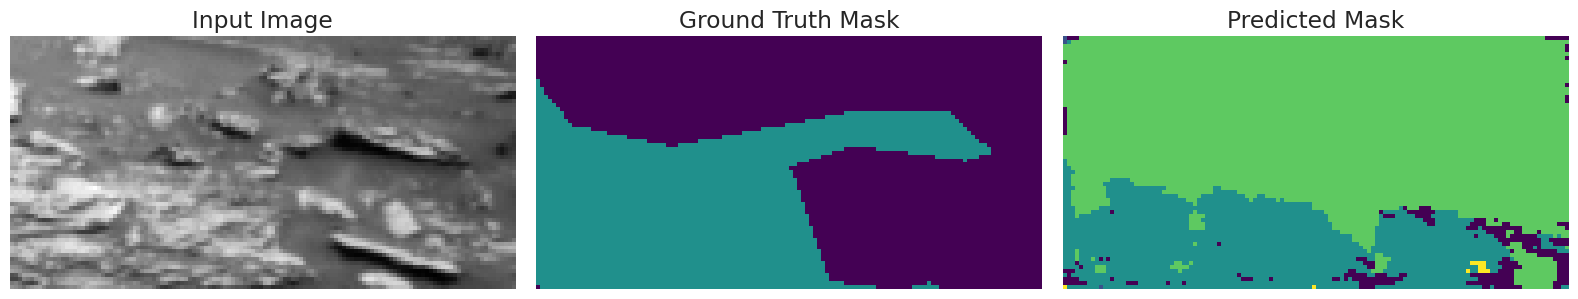

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 789ms/step - loss: 0.7934 - mean_iou: 0.4327 - val_loss: 1.3801 - val_mean_iou: 0.1422
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.7695 - mean_iou: 0.4449 - val_loss: 1.4410 - val_mean_iou: 0.1370
Epoch 23/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - loss: 0.7265 - mean_iou: 0.4668 - val_loss: 1.2754 - val_mean_iou: 0.2061
Epoch 24/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - loss: 0.7200 - mean_iou: 0.4693 - val_loss: 1.2641 - val_mean_iou: 0.2323
Epoch 25/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step - loss: 0.7136 - mean_iou: 0.4800 - val_loss: 1.1226 - val_mean_iou: 0.2534
Epoch 26/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - loss: 0.6976 - mean_iou: 0.5080

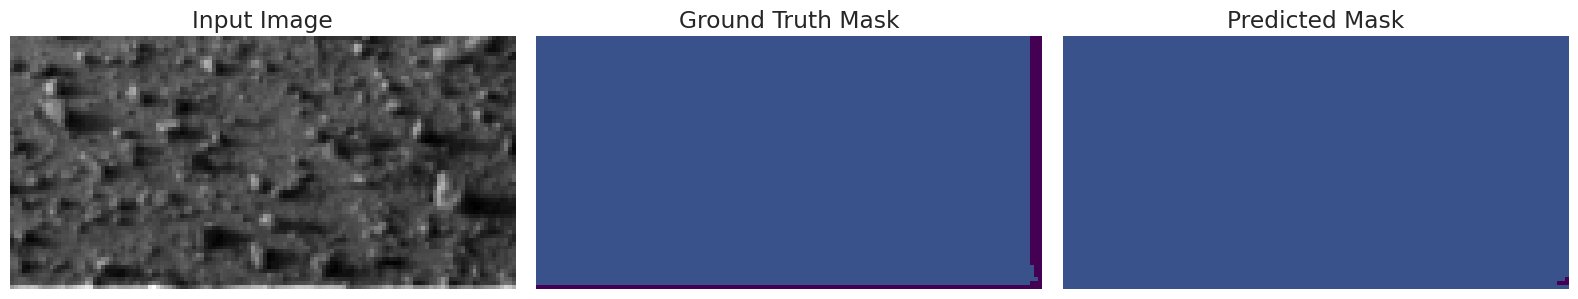

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - loss: 0.6979 - mean_iou: 0.5068 - val_loss: 1.2883 - val_mean_iou: 0.2681
Epoch 27/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - loss: 0.6629 - mean_iou: 0.5179 - val_loss: 1.1935 - val_mean_iou: 0.2530
Epoch 28/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - loss: 0.6880 - mean_iou: 0.4829 - val_loss: 1.2494 - val_mean_iou: 0.3184
Epoch 29/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - loss: 0.6731 - mean_iou: 0.5053 - val_loss: 1.0965 - val_mean_iou: 0.3232
Epoch 30/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - loss: 0.6464 - mean_iou: 0.5175 - val_loss: 1.2423 - val_mean_iou: 0.2609
Epoch 31/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - loss: 0.6398 - mean_iou: 0.5490

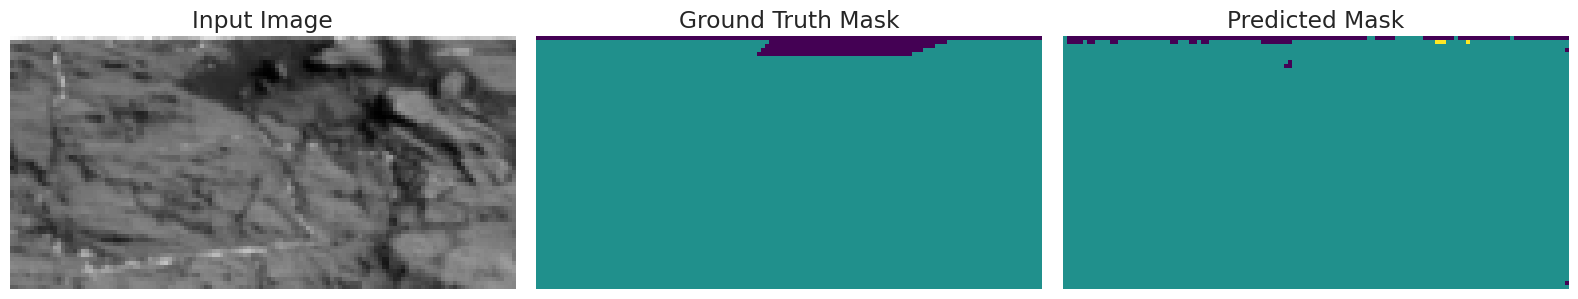

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 786ms/step - loss: 0.6406 - mean_iou: 0.5470 - val_loss: 1.3104 - val_mean_iou: 0.2729
Epoch 32/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.6546 - mean_iou: 0.5110 - val_loss: 0.9961 - val_mean_iou: 0.3391
Epoch 33/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - loss: 0.6075 - mean_iou: 0.5636 - val_loss: 1.1434 - val_mean_iou: 0.2817
Epoch 34/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step - loss: 0.6137 - mean_iou: 0.5434 - val_loss: 1.0905 - val_mean_iou: 0.2956
Epoch 35/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.5851 - mean_iou: 0.5711 - val_loss: 1.0790 - val_mean_iou: 0.3226
Epoch 36/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - loss: 0.5725 - mean_iou: 0.5659

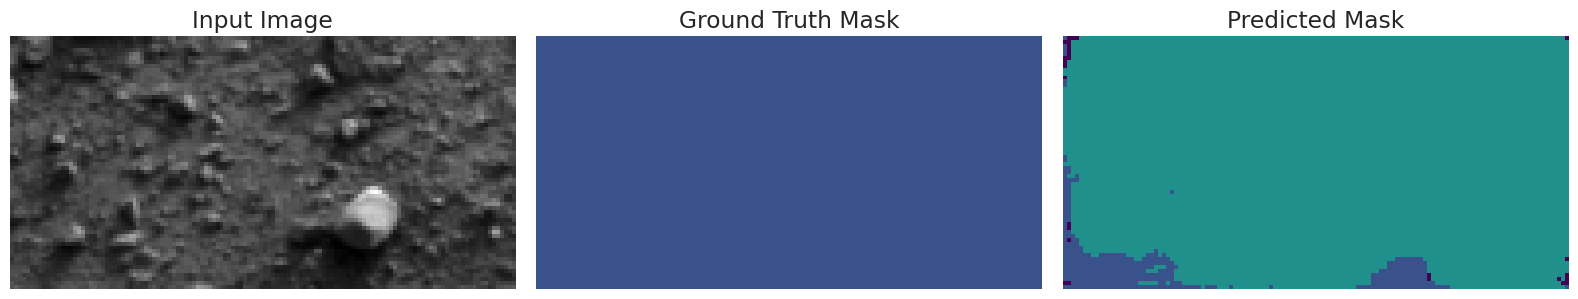

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 805ms/step - loss: 0.5763 - mean_iou: 0.5612 - val_loss: 1.0908 - val_mean_iou: 0.3245
Epoch 37/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - loss: 0.5642 - mean_iou: 0.5949 - val_loss: 1.2589 - val_mean_iou: 0.2991
Epoch 38/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 753ms/step - loss: 0.5603 - mean_iou: 0.5883 - val_loss: 0.9817 - val_mean_iou: 0.3738
Epoch 39/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - loss: 0.5266 - mean_iou: 0.5977 - val_loss: 0.9513 - val_mean_iou: 0.3493
Epoch 40/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.5654 - mean_iou: 0.5544 - val_loss: 1.0475 - val_mean_iou: 0.3217
Epoch 41/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - loss: 0.5383 - mean_iou: 0.5827

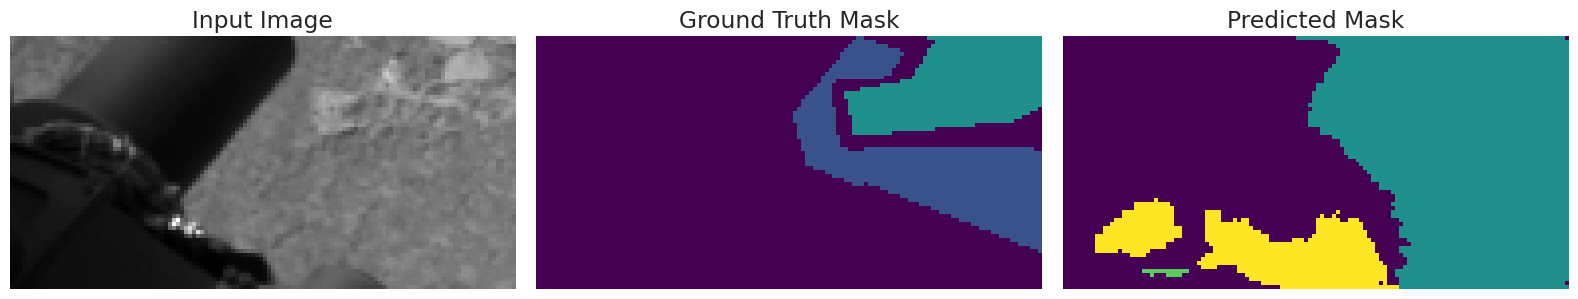

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 789ms/step - loss: 0.5396 - mean_iou: 0.5812 - val_loss: 1.0362 - val_mean_iou: 0.3398
Epoch 42/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.5388 - mean_iou: 0.6107 - val_loss: 0.7594 - val_mean_iou: 0.3831
Epoch 43/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - loss: 0.5402 - mean_iou: 0.6107 - val_loss: 0.8704 - val_mean_iou: 0.4107
Epoch 44/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - loss: 0.5274 - mean_iou: 0.6171 - val_loss: 1.0994 - val_mean_iou: 0.3236
Epoch 45/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - loss: 0.5332 - mean_iou: 0.6040 - val_loss: 1.2387 - val_mean_iou: 0.3339
Epoch 46/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 0.5058 - mean_iou: 0.6249

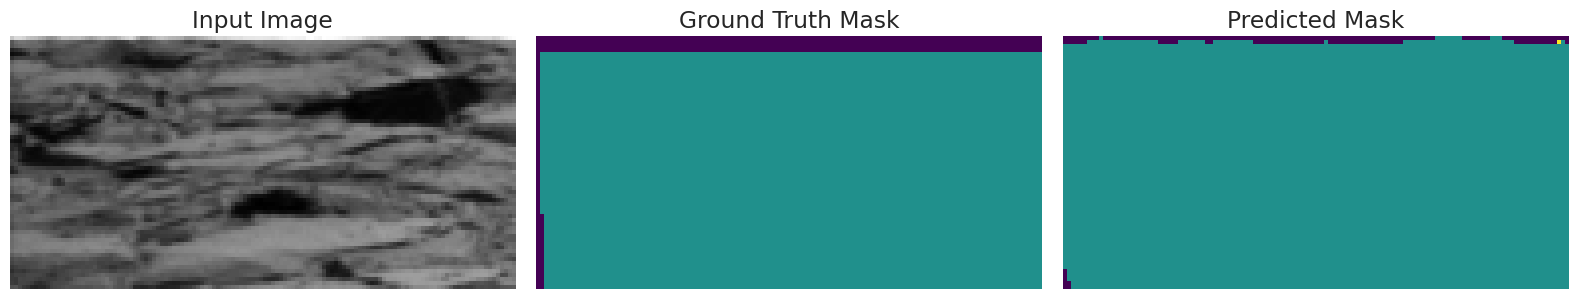

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 807ms/step - loss: 0.5051 - mean_iou: 0.6252 - val_loss: 1.0539 - val_mean_iou: 0.3766
Epoch 47/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - loss: 0.4979 - mean_iou: 0.6113 - val_loss: 1.0126 - val_mean_iou: 0.3346
Epoch 48/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - loss: 0.4731 - mean_iou: 0.6544 - val_loss: 0.8770 - val_mean_iou: 0.3872
Epoch 49/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - loss: 0.4614 - mean_iou: 0.6241 - val_loss: 0.9469 - val_mean_iou: 0.4169
Epoch 50/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - loss: 0.4801 - mean_iou: 0.6347 - val_loss: 0.9225 - val_mean_iou: 0.3721
Epoch 51/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - loss: 0.4733 - mean_iou: 0.6124

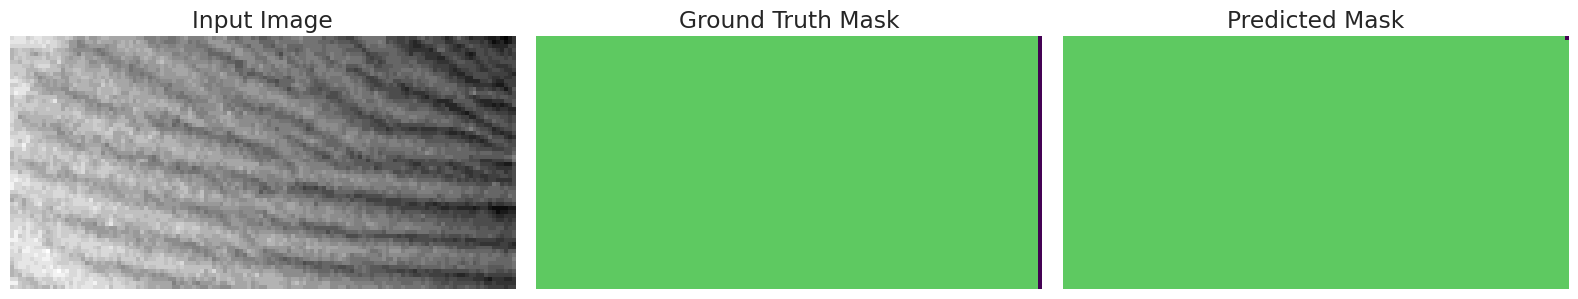

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 793ms/step - loss: 0.4704 - mean_iou: 0.6188 - val_loss: 0.9324 - val_mean_iou: 0.3809
Epoch 52/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - loss: 0.4557 - mean_iou: 0.6524 - val_loss: 0.8317 - val_mean_iou: 0.4108
Epoch 53/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.4567 - mean_iou: 0.6525 - val_loss: 0.9534 - val_mean_iou: 0.3954
Epoch 54/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.4658 - mean_iou: 0.6279 - val_loss: 0.9485 - val_mean_iou: 0.3960
Epoch 55/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - loss: 0.4383 - mean_iou: 0.6585 - val_loss: 0.8486 - val_mean_iou: 0.3994
Epoch 56/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - loss: 0.4238 - mean_iou: 0.6533

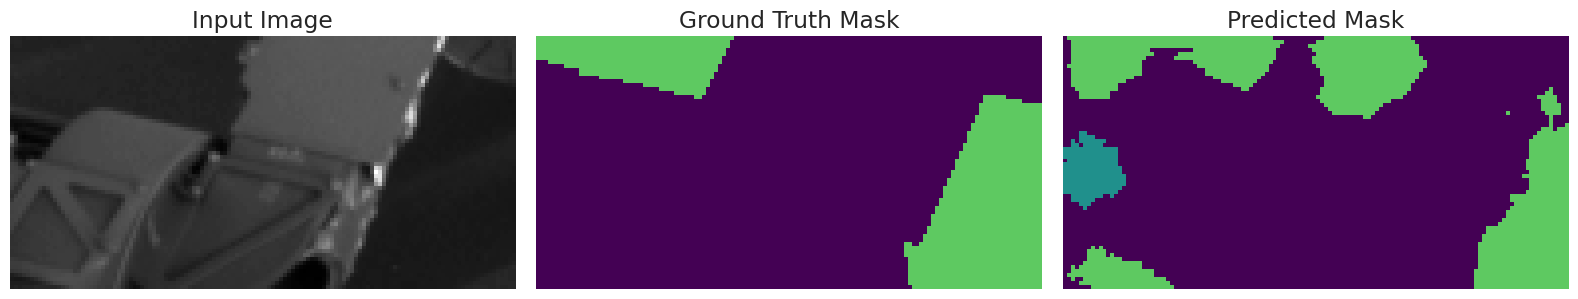

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 808ms/step - loss: 0.4238 - mean_iou: 0.6553 - val_loss: 0.8581 - val_mean_iou: 0.4042
Epoch 57/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - loss: 0.4364 - mean_iou: 0.6314 - val_loss: 0.9548 - val_mean_iou: 0.3477
Epoch 58/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.4282 - mean_iou: 0.5945 - val_loss: 0.8500 - val_mean_iou: 0.4110
Epoch 59/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.4411 - mean_iou: 0.6298 - val_loss: 0.9117 - val_mean_iou: 0.4183
Epoch 60/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - loss: 0.4136 - mean_iou: 0.6505 - val_loss: 0.7744 - val_mean_iou: 0.4040
Epoch 61/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 0.4049 - mean_iou: 0.6546

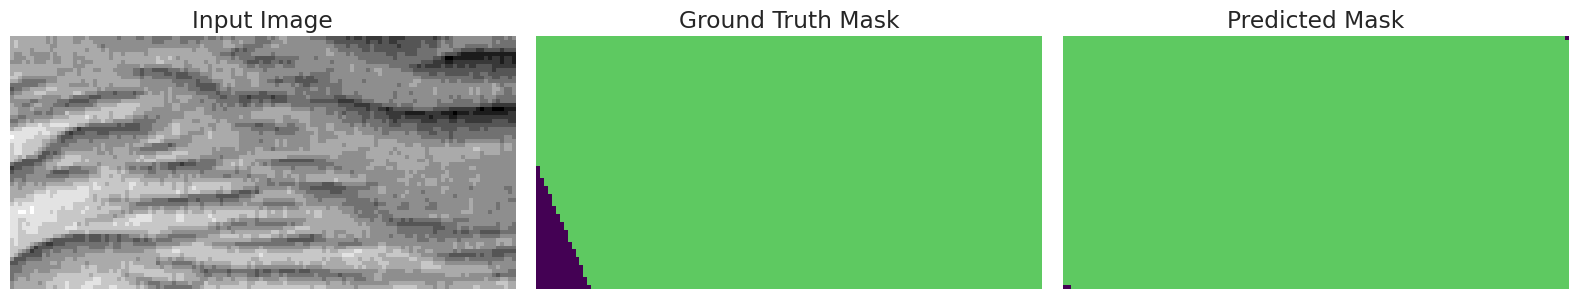

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 785ms/step - loss: 0.4072 - mean_iou: 0.6539 - val_loss: 0.9228 - val_mean_iou: 0.4004
Epoch 62/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - loss: 0.4034 - mean_iou: 0.6517 - val_loss: 0.9386 - val_mean_iou: 0.3667
Epoch 63/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - loss: 0.3853 - mean_iou: 0.6792 - val_loss: 1.0258 - val_mean_iou: 0.3547
Epoch 64/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 738ms/step - loss: 0.3948 - mean_iou: 0.6810 - val_loss: 0.8708 - val_mean_iou: 0.4219
Epoch 65/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.3777 - mean_iou: 0.6831 - val_loss: 0.8067 - val_mean_iou: 0.4326
Epoch 66/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 0.3658 - mean_iou: 0.6505

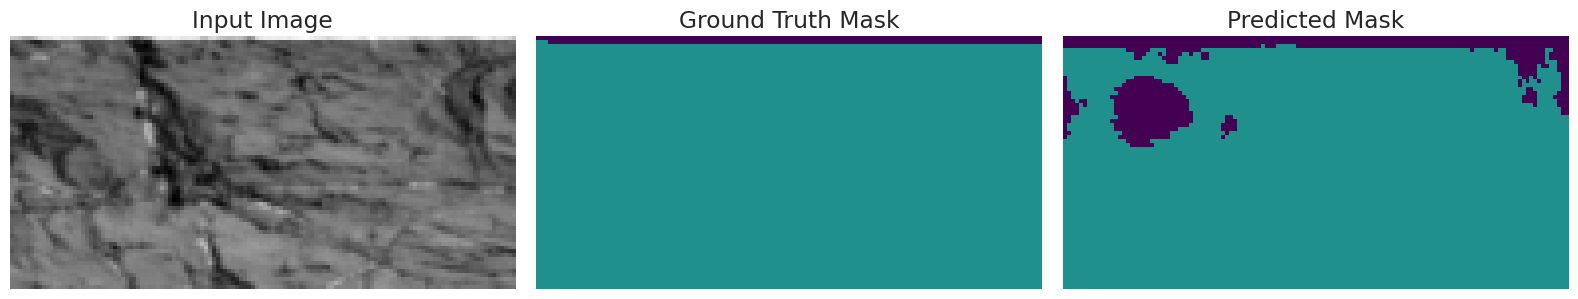

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 801ms/step - loss: 0.3699 - mean_iou: 0.6479 - val_loss: 0.9161 - val_mean_iou: 0.3384
Epoch 67/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - loss: 0.3885 - mean_iou: 0.6590 - val_loss: 0.9581 - val_mean_iou: 0.3448
Epoch 68/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - loss: 0.3759 - mean_iou: 0.6738 - val_loss: 0.9203 - val_mean_iou: 0.4095
Epoch 69/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 726ms/step - loss: 0.3640 - mean_iou: 0.6635 - val_loss: 0.7569 - val_mean_iou: 0.3934
Epoch 70/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 728ms/step - loss: 0.3676 - mean_iou: 0.6715 - val_loss: 0.8718 - val_mean_iou: 0.4407
Epoch 71/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - loss: 0.3608 - mean_iou: 0.6523

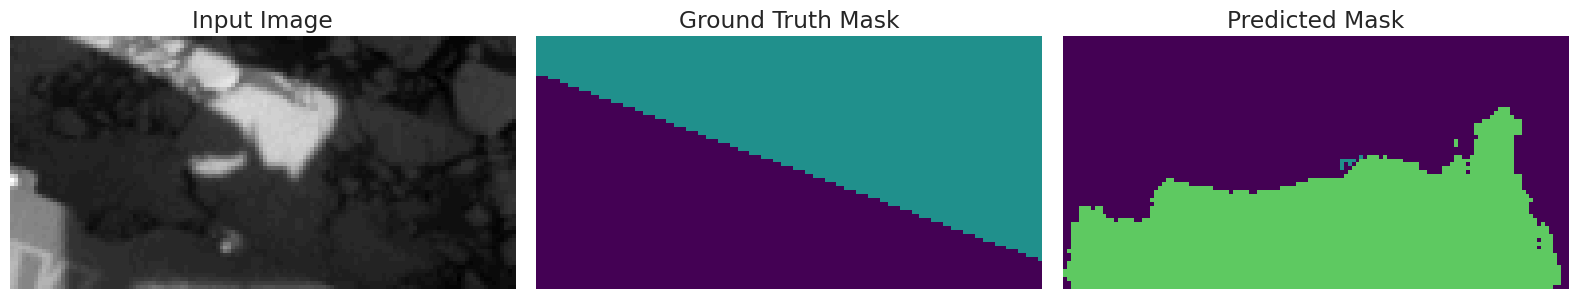

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - loss: 0.3595 - mean_iou: 0.6556 - val_loss: 0.9418 - val_mean_iou: 0.3851
Epoch 72/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.3460 - mean_iou: 0.6863 - val_loss: 0.8977 - val_mean_iou: 0.4129
Epoch 73/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - loss: 0.3467 - mean_iou: 0.6939 - val_loss: 0.7753 - val_mean_iou: 0.4481
Epoch 74/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - loss: 0.3324 - mean_iou: 0.6917 - val_loss: 1.0465 - val_mean_iou: 0.4420
Epoch 75/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.3220 - mean_iou: 0.6981 - val_loss: 0.7926 - val_mean_iou: 0.4349
Epoch 76/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - loss: 0.3110 - mean_iou: 0.7042

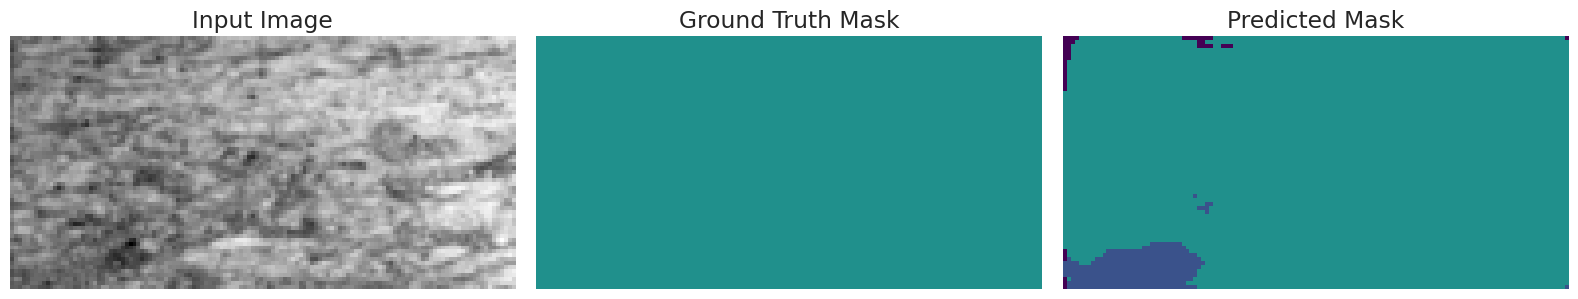

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 781ms/step - loss: 0.3130 - mean_iou: 0.6999 - val_loss: 0.8603 - val_mean_iou: 0.3980
Epoch 77/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - loss: 0.3065 - mean_iou: 0.7027 - val_loss: 0.6155 - val_mean_iou: 0.4469
Epoch 78/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - loss: 0.3223 - mean_iou: 0.6670 - val_loss: 0.9383 - val_mean_iou: 0.4520
Epoch 79/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 701ms/step - loss: 0.2775 - mean_iou: 0.7082 - val_loss: 0.7078 - val_mean_iou: 0.4122
Epoch 80/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.2987 - mean_iou: 0.7082 - val_loss: 0.9932 - val_mean_iou: 0.4495
Epoch 81/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - loss: 0.3029 - mean_iou: 0.6737

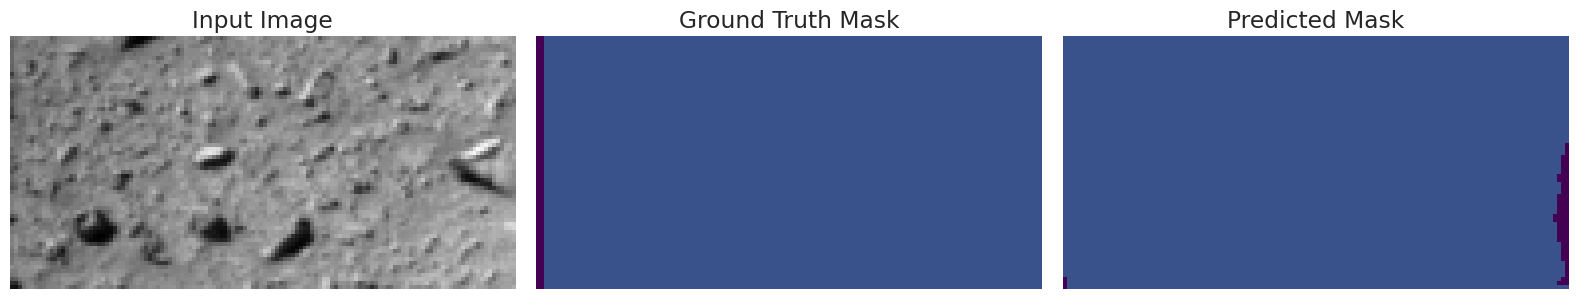

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 803ms/step - loss: 0.3019 - mean_iou: 0.6779 - val_loss: 0.8588 - val_mean_iou: 0.4104
Epoch 82/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step - loss: 0.2939 - mean_iou: 0.7000 - val_loss: 0.9045 - val_mean_iou: 0.4296
Epoch 83/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - loss: 0.2862 - mean_iou: 0.7048 - val_loss: 0.7446 - val_mean_iou: 0.4397
Epoch 84/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - loss: 0.2896 - mean_iou: 0.7089 - val_loss: 0.8549 - val_mean_iou: 0.4502
Epoch 85/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - loss: 0.2851 - mean_iou: 0.7085 - val_loss: 1.1151 - val_mean_iou: 0.3423
Epoch 86/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 0.2716 - mean_iou: 0.7242

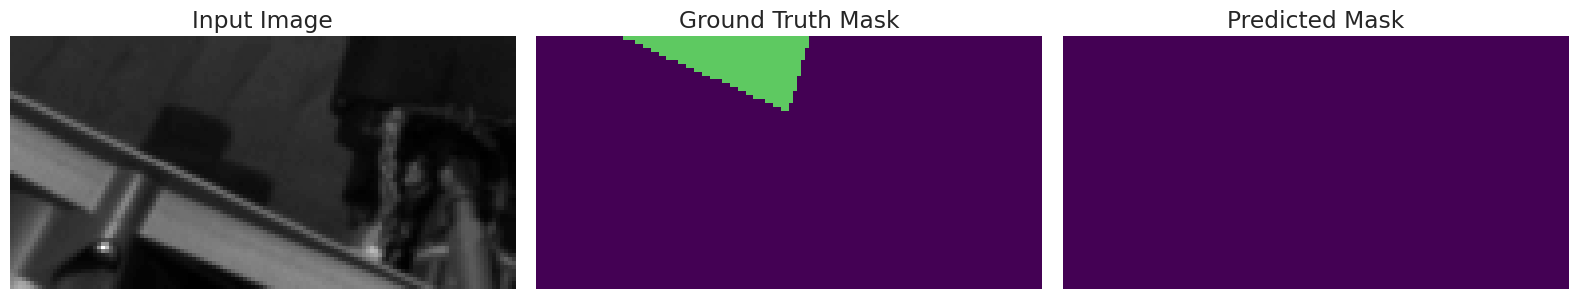

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step - loss: 0.2718 - mean_iou: 0.7231 - val_loss: 1.0711 - val_mean_iou: 0.3668
Epoch 87/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - loss: 0.2764 - mean_iou: 0.7078 - val_loss: 1.0481 - val_mean_iou: 0.4160
Epoch 88/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.2864 - mean_iou: 0.6944 - val_loss: 0.8636 - val_mean_iou: 0.3989
Epoch 89/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.2590 - mean_iou: 0.7061 - val_loss: 0.8105 - val_mean_iou: 0.4128
Epoch 90/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.2626 - mean_iou: 0.7140 - val_loss: 0.9578 - val_mean_iou: 0.3604
Epoch 91/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - loss: 0.2665 - mean_iou: 0.7028

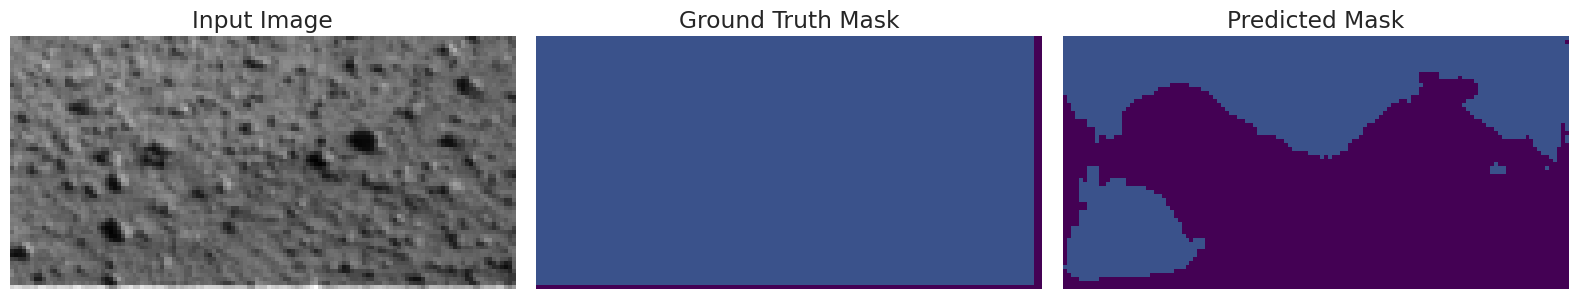

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 801ms/step - loss: 0.2664 - mean_iou: 0.7037 - val_loss: 1.0275 - val_mean_iou: 0.3809
Epoch 92/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - loss: 0.2608 - mean_iou: 0.7284 - val_loss: 0.9409 - val_mean_iou: 0.3597
Epoch 93/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - loss: 0.2646 - mean_iou: 0.7212 - val_loss: 0.8179 - val_mean_iou: 0.4227
Epoch 94/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 752ms/step - loss: 0.2630 - mean_iou: 0.7162 - val_loss: 1.1297 - val_mean_iou: 0.4196
Epoch 95/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - loss: 0.2444 - mean_iou: 0.7253 - val_loss: 0.8274 - val_mean_iou: 0.4689
Epoch 96/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 0.2592 - mean_iou: 0.7302

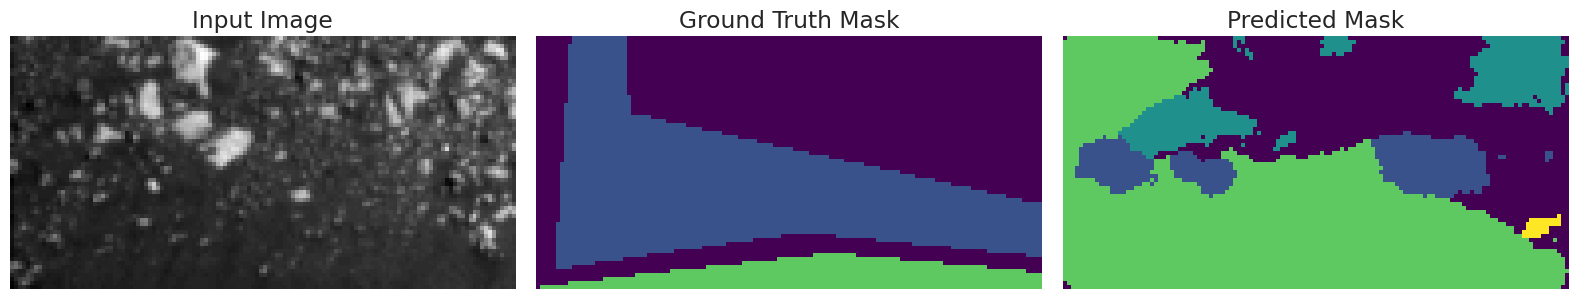

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 809ms/step - loss: 0.2600 - mean_iou: 0.7297 - val_loss: 0.7282 - val_mean_iou: 0.4841
Epoch 97/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - loss: 0.2365 - mean_iou: 0.7210 - val_loss: 0.8123 - val_mean_iou: 0.4237
Epoch 98/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - loss: 0.2415 - mean_iou: 0.7130 - val_loss: 0.9632 - val_mean_iou: 0.4166
Epoch 99/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.2340 - mean_iou: 0.7337 - val_loss: 0.6990 - val_mean_iou: 0.4550
Epoch 100/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.2413 - mean_iou: 0.6998 - val_loss: 0.6458 - val_mean_iou: 0.4552
Epoch 101/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - loss: 0.2296 - mean_iou: 0.7361

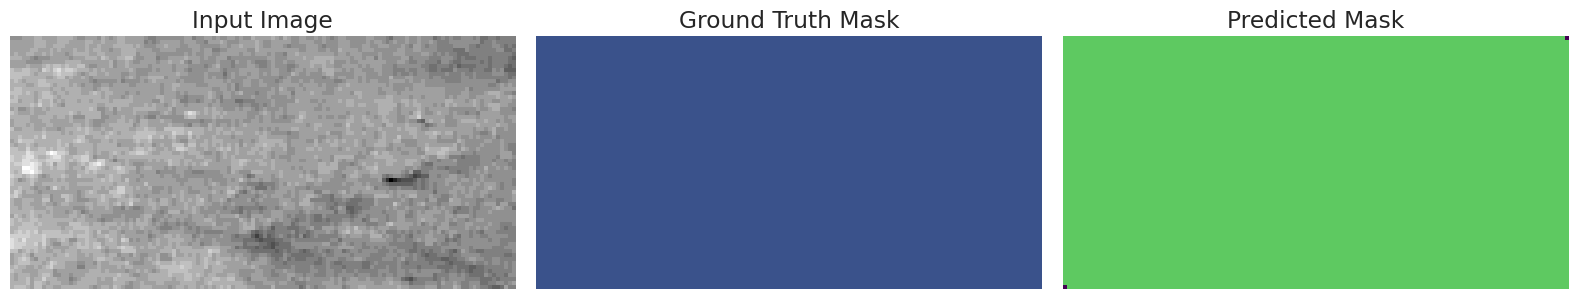

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 804ms/step - loss: 0.2291 - mean_iou: 0.7362 - val_loss: 0.9535 - val_mean_iou: 0.3639
Epoch 102/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - loss: 0.2367 - mean_iou: 0.7236 - val_loss: 0.8553 - val_mean_iou: 0.3955
Epoch 103/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step - loss: 0.2196 - mean_iou: 0.7107 - val_loss: 1.0226 - val_mean_iou: 0.3811
Epoch 104/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 747ms/step - loss: 0.2203 - mean_iou: 0.7274 - val_loss: 0.8673 - val_mean_iou: 0.4755
Epoch 105/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 704ms/step - loss: 0.2199 - mean_iou: 0.7447 - val_loss: 1.0008 - val_mean_iou: 0.4072
Epoch 106/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - loss: 0.2148 - mean_iou: 0.7255

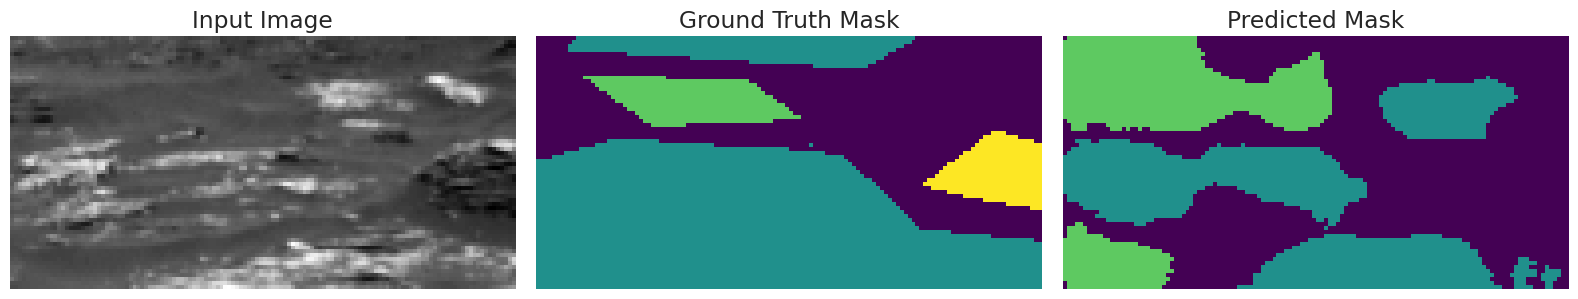

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - loss: 0.2178 - mean_iou: 0.7259 - val_loss: 0.8251 - val_mean_iou: 0.3687
Epoch 107/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - loss: 0.2176 - mean_iou: 0.7148 - val_loss: 0.9380 - val_mean_iou: 0.4126
Epoch 108/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 720ms/step - loss: 0.2028 - mean_iou: 0.7501 - val_loss: 1.1003 - val_mean_iou: 0.3794
Epoch 109/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 722ms/step - loss: 0.2160 - mean_iou: 0.7375 - val_loss: 1.1760 - val_mean_iou: 0.3273
Epoch 110/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - loss: 0.2236 - mean_iou: 0.7227 - val_loss: 1.2752 - val_mean_iou: 0.3165
Epoch 111/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 0.2324 - mean_iou: 0.7169

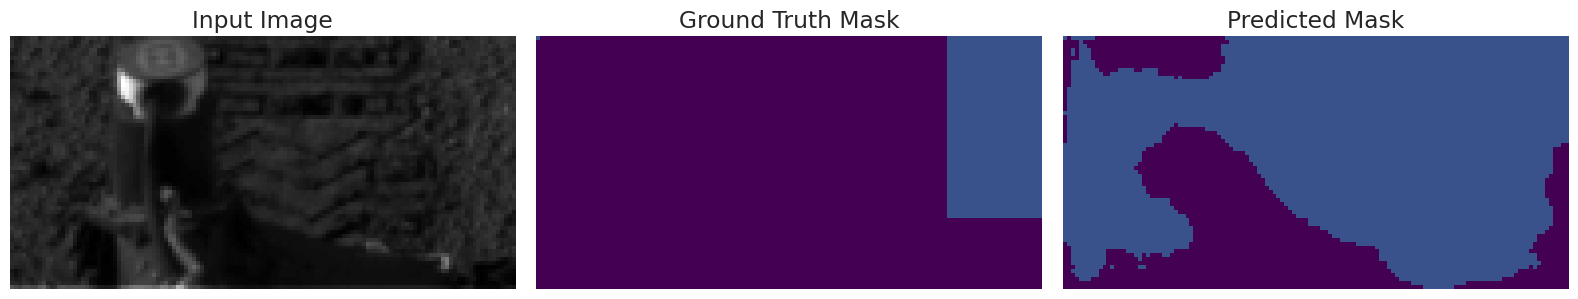

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 787ms/step - loss: 0.2344 - mean_iou: 0.7179 - val_loss: 1.1333 - val_mean_iou: 0.3915
Epoch 112/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - loss: 0.2304 - mean_iou: 0.7255 - val_loss: 0.7542 - val_mean_iou: 0.4418
Epoch 113/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step - loss: 0.2359 - mean_iou: 0.7331 - val_loss: 0.8508 - val_mean_iou: 0.3922
Epoch 114/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 729ms/step - loss: 0.2175 - mean_iou: 0.7304 - val_loss: 0.9644 - val_mean_iou: 0.4228
Epoch 115/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.2083 - mean_iou: 0.7385 - val_loss: 0.7064 - val_mean_iou: 0.5021
Epoch 116/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - loss: 0.2019 - mean_iou: 0.7468

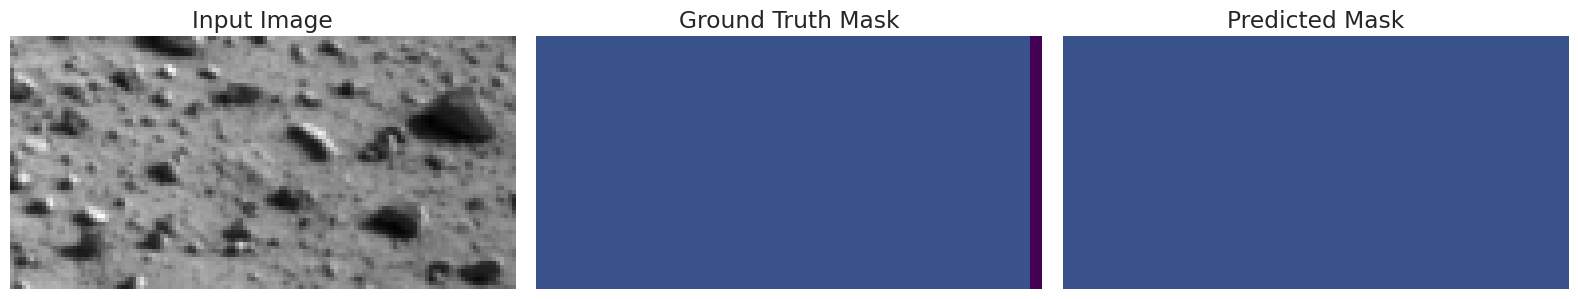

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 790ms/step - loss: 0.2036 - mean_iou: 0.7457 - val_loss: 0.8240 - val_mean_iou: 0.4984
Epoch 117/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.1885 - mean_iou: 0.7361 - val_loss: 0.8466 - val_mean_iou: 0.4121
Epoch 118/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - loss: 0.1835 - mean_iou: 0.7391 - val_loss: 1.0162 - val_mean_iou: 0.3994
Epoch 119/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - loss: 0.1952 - mean_iou: 0.7415 - val_loss: 0.9623 - val_mean_iou: 0.4043
Epoch 120/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.1876 - mean_iou: 0.7410 - val_loss: 1.2267 - val_mean_iou: 0.3711
Epoch 121/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - loss: 0.1862 - mean_iou: 0.7399

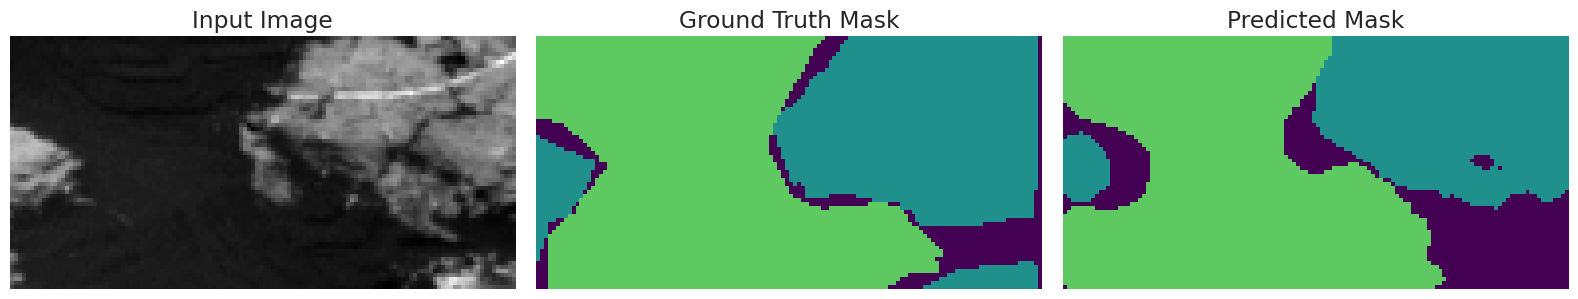

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 792ms/step - loss: 0.1875 - mean_iou: 0.7398 - val_loss: 1.0762 - val_mean_iou: 0.4017
Epoch 122/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 0.1886 - mean_iou: 0.7403 - val_loss: 0.9393 - val_mean_iou: 0.4429
Epoch 123/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - loss: 0.1831 - mean_iou: 0.7368 - val_loss: 1.0533 - val_mean_iou: 0.4136
Epoch 124/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 741ms/step - loss: 0.1825 - mean_iou: 0.7515 - val_loss: 0.8930 - val_mean_iou: 0.3898
Epoch 125/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 718ms/step - loss: 0.1871 - mean_iou: 0.7424 - val_loss: 0.7726 - val_mean_iou: 0.4501
Epoch 126/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - loss: 0.1734 - mean_iou: 0.7458

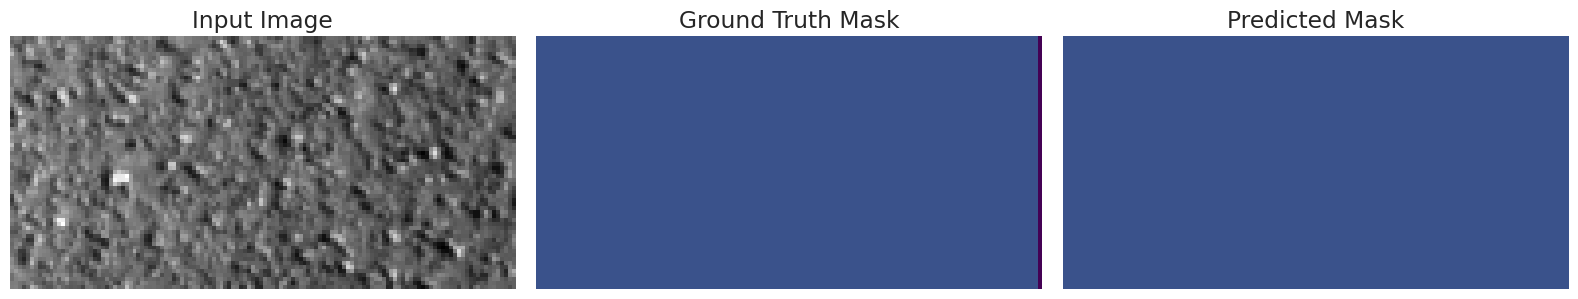

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 812ms/step - loss: 0.1765 - mean_iou: 0.7453 - val_loss: 0.9558 - val_mean_iou: 0.3759
Epoch 127/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - loss: 0.1738 - mean_iou: 0.7503 - val_loss: 1.1235 - val_mean_iou: 0.3772
Epoch 128/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.1748 - mean_iou: 0.7540 - val_loss: 0.9415 - val_mean_iou: 0.4425
Epoch 129/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.1675 - mean_iou: 0.7457 - val_loss: 0.9651 - val_mean_iou: 0.3807
Epoch 130/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 715ms/step - loss: 0.1746 - mean_iou: 0.7520 - val_loss: 0.9453 - val_mean_iou: 0.4280
Epoch 131/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - loss: 0.1722 - mean_iou: 0.7518

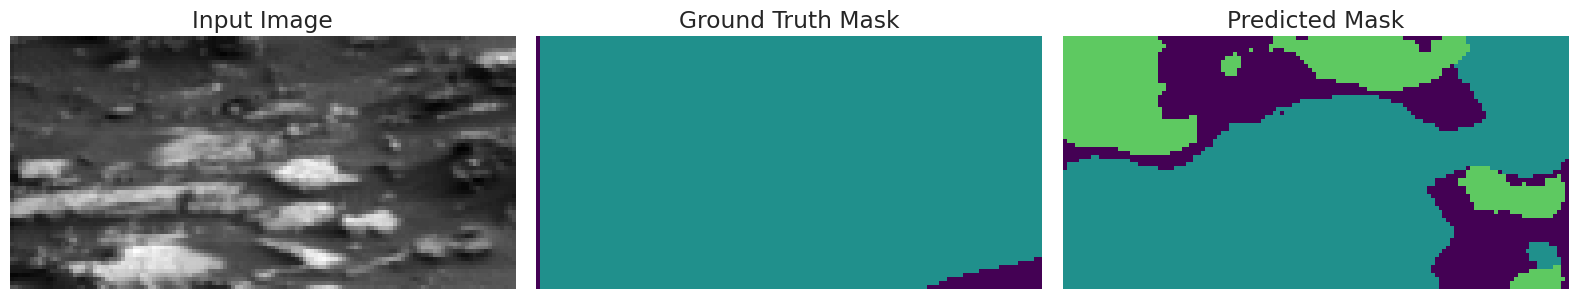

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 813ms/step - loss: 0.1724 - mean_iou: 0.7524 - val_loss: 0.8897 - val_mean_iou: 0.4471
Epoch 132/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - loss: 0.1667 - mean_iou: 0.7449 - val_loss: 0.8881 - val_mean_iou: 0.4509
Epoch 133/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.1647 - mean_iou: 0.7429 - val_loss: 1.0217 - val_mean_iou: 0.3639
Epoch 134/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - loss: 0.1684 - mean_iou: 0.7545 - val_loss: 1.1874 - val_mean_iou: 0.4059
Epoch 135/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 719ms/step - loss: 0.1655 - mean_iou: 0.7527 - val_loss: 0.8826 - val_mean_iou: 0.4502
Final validation Mean Intersection Over Union: 50.21%


In [116]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

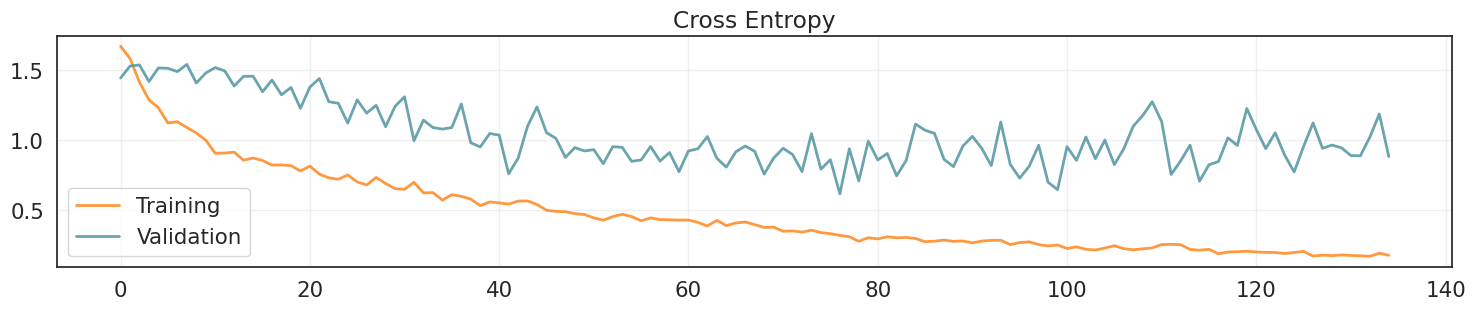

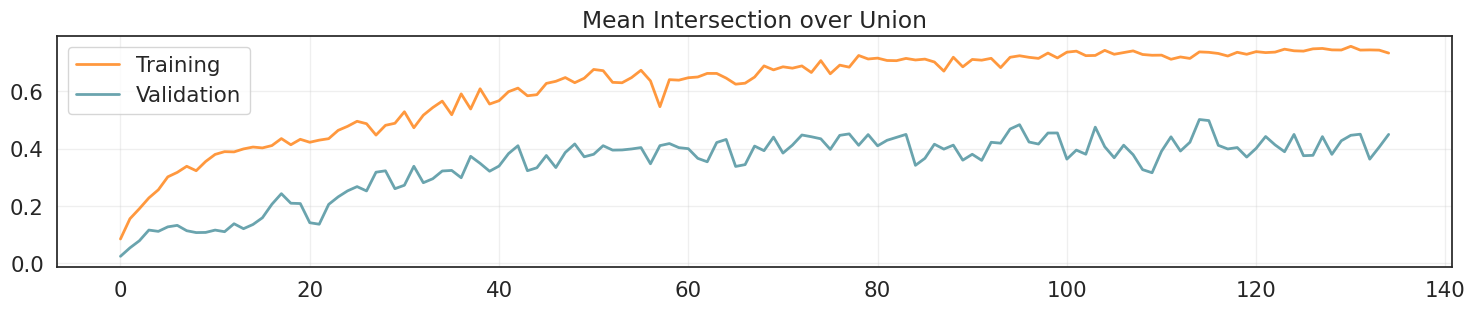

In [117]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
#plt.figure(figsize=(18, 3))
#plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
#plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
#plt.title('Accuracy')
#plt.legend()
#plt.grid(alpha=0.3)
#plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


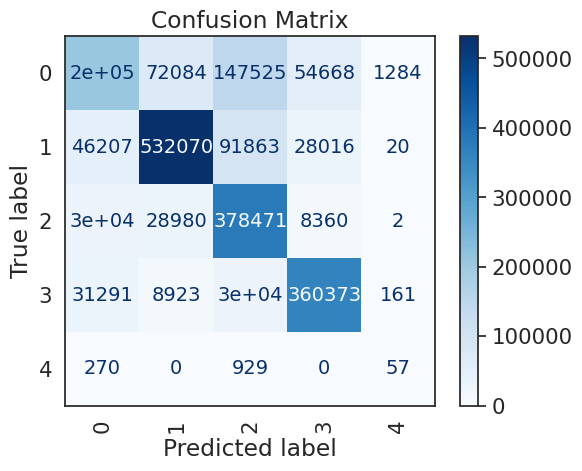

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.
    
    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []
    
    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_dataset, [0, 1,2,3,4])

In [119]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
Predictions shape: (10022, 64, 128)


In [120]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [121]:
from time import time

# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)